In [1]:
from pathlib import Path

import numpy as np
import cv2
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
import skimage
import tqdm

import seed_detector.tools as sdt
from seed_detector.tools import resample_polygon, polygon_area, get_contours
def reset_starting_point(contour):
    best_i = 0
    best_d = np.inf
    mid_x = (contour[:, 1].max() - contour[:, 1].min()) / 2 + contour[:, 1].min()
    mid_y = (contour[:, 0].max() - contour[:, 0].min()) / 2 + contour[:, 0].min()
    for i in range(contour.shape[0]):
        d = np.abs(contour[i, 1] - mid_x)
        if d < best_d and contour[i, 0] < mid_y:
            best_d = d
            best_i = i
    return np.r_[contour[best_i:, ], contour[:best_i, ]]

In [27]:
test_dir = './test_align/'
mask_files = list(Path(test_dir).rglob('*/masks/*.png'))

contours = []
for mask_file in tqdm.tqdm(mask_files):
    mask = cv2.imread(str(mask_file), cv2.IMREAD_UNCHANGED)
    c = get_contours(mask, 1)
    if len(c) < 1:
        print(f'Could not find contour in {mask_file}.')
        continue
    
    # get largest contour (it is possible that small contours are introduced by aligning the images)
    contour = sorted(c, key=lambda c: c.shape[0])[0]
    # set first contour point to lower middle
    contour = reset_starting_point(contour)
    # resample contour to 50 points
    contour = resample_polygon(contour, 50)
    # "standardize" contour (for size invariance)
    contour = (contour - contour.mean(0)) / contour[:, 0].max()
    # 2D -> 1D (x1,y1,x2,y2,...,xn,yn)
    contour = contour.ravel()

    contours.append(contour)

 64%|███████████████████████▊             | 66067/102480 [01:08<00:44, 813.10it/s]

Could not find contour in test_align/Scannen0108_cal/masks/Scannen0108_cal_36_mask.png.


 85%|██████████████████████████████▍     | 86618/102480 [01:26<00:09, 1682.05it/s]

Could not find contour in test_align/Scannen1276_cal/masks/Scannen1276_cal_0_mask.png.


100%|███████████████████████████████████| 102480/102480 [01:38<00:00, 1036.47it/s]


In [55]:
# PCA
x = np.array(contours)

pca = sklearn.decomposition.PCA(5)
pca.fit(x)
r = pca.transform(x)

In [156]:
# K-Means
k=20

km = sklearn.cluster.KMeans(n_clusters=k)
km.fit(r)
cl = km.predict(r)

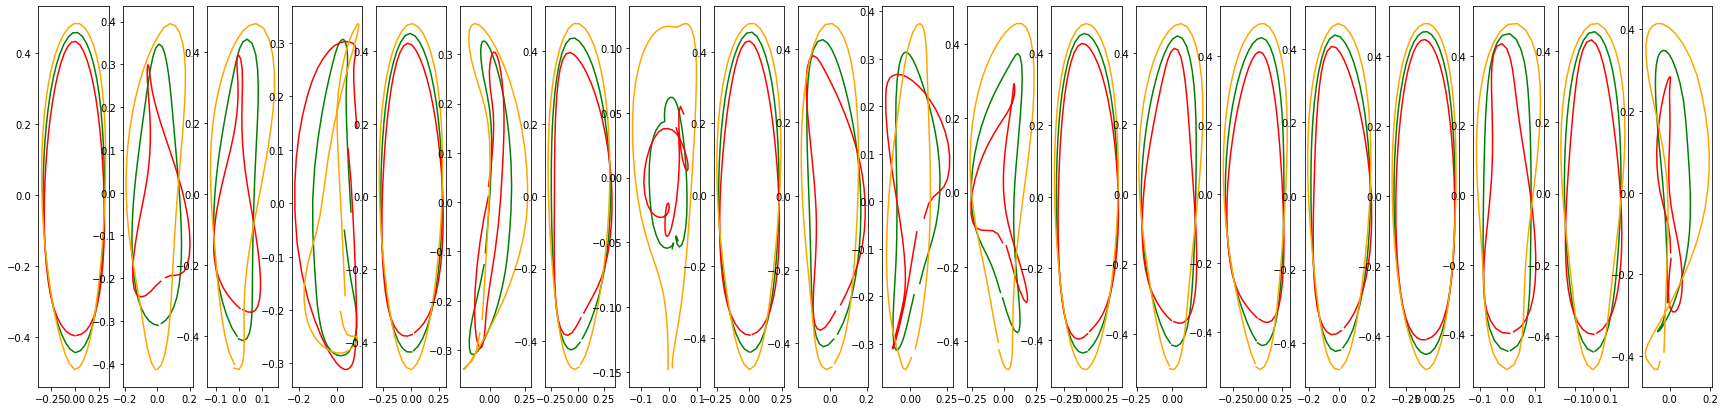

In [157]:
fig, axs = plt.subplots(1, k, figsize=[30, 7])
for i in range(k):
    r_tmp = r[cl == i,:]
    m = pca.inverse_transform(r_tmp.mean(axis=0)).reshape(-1, 2)
    axs[i].plot(m[:, 1], m[:, 0], color='green')
    
    # plot mean +- sd in PC-space (visualizes cluster homogeneity)
    m_u = pca.inverse_transform(r_tmp.mean(axis=0) + r_tmp.std(axis=0)).reshape(-1, 2)
    m_l = pca.inverse_transform(r_tmp.mean(axis=0) - r_tmp.std(axis=0)).reshape(-1, 2)
    axs[i].plot(m_u[:, 1], m_u[:, 0], color='red')
    axs[i].plot(m_l[:, 1], m_l[:, 0], color='orange')

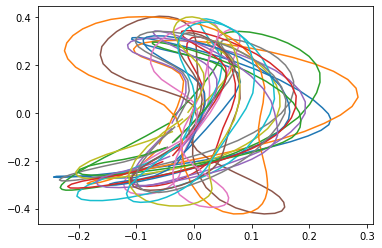

In [162]:
# inspect one cluster (plots 20 randomly drawn contours from a cluster)
test_cluster = 5
r_tmp = r[cl == test_cluster,]
r_idcs = np.random.choice(np.arange(r_tmp.shape[0]), size=20)
for c in r_tmp[r_idcs, :]:
    yx = pca.inverse_transform(c).reshape(-1, 2)
    plt.plot(yx[:, 1], yx[:, 0])